# California vehicle fuel type count by zip code

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:,.2f}'.format
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Read data from California Department of Motor Vehicles - current as of October 2018

In [2]:
# https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code
src = pd.read_csv('https://data.ca.gov/dataset/15179472-adeb-4df6-920a-20640d02b08c/\
resource/d304108a-06c1-462f-a144-981dd0109900/\
download/vehicle-fuel-type-count-by-zip-code.csv', low_memory=False)

In [3]:
vehicles = pd.DataFrame(src)

### Clean up field names

In [4]:
vehicles.columns = vehicles.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [5]:
vehicles.rename(columns={"zip_code": "zip"}, inplace=True)

### How many vehicles are we talking about? 

In [6]:
'{:,.0f}'.format(vehicles.vehicles.sum())

'31,137,994'

### Remove few 2019 models, older models and those listed as out of state

In [7]:
# vehicles = pd.DataFrame(vehicles[(vehicles['model_year'] != '2019') &\
#           (vehicles['model_year'] != '<2006') &\
#           (vehicles['zip'] != 'OOS')\
#          ])

### What's left?

In [8]:
'{:,.0f}'.format(vehicles.vehicles.sum())

'31,137,994'

### How many don't rely solely on gasoline?

In [9]:
nongas = vehicles[(vehicles['fuel'] != 'Gasoline')]

In [10]:
'{:,.0f}'.format(nongas.vehicles.sum())

'4,159,196'

In [11]:
nongas.head(20)

,date,zip,model_year,fuel,make,duty,vehicles
4,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,Heavy,55
5,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,Light,2
6,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,WHITE,Heavy,19
7,10/1/2018,90000,<2006,Battery Electric,OTHER/UNK,Heavy,4
15,10/1/2018,90000,<2006,Other,OTHER/UNK,Light,6
16,10/1/2018,90001,2006,Diesel and Diesel Hybrid,FORD,Heavy,16
17,10/1/2018,90001,2006,Diesel and Diesel Hybrid,OTHER/UNK,Heavy,23
18,10/1/2018,90001,2006,Diesel and Diesel Hybrid,OTHER/UNK,Light,9
19,10/1/2018,90001,2006,Battery Electric,OTHER/UNK,Light,1
20,10/1/2018,90001,2006,Flex-Fuel,CHEVROLET,Light,41


---

### ZIP code points

In [12]:
zips_point = gpd.read_file('/Users/mhustiles/data/data/GIS/zipcodes.geojson')

In [13]:
zips_point['zip'] = zips_point['zip'].astype(str)

In [14]:
ca_zips_point = zips_point[zips_point['state'] == 'CA']

### ZIP code boundaries

In [15]:
# Filtered CA from this national file maintained by Esri: 
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_ZIP_Code_Areas_anaylsis/FeatureServer/0/
zips_poly_pop = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri.geojson')
zips_poly = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri-demographics.geojson')

In [16]:
zips_poly.columns = zips_poly.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

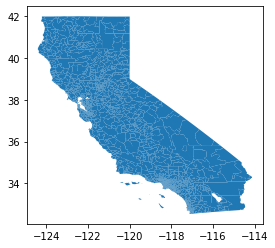

In [17]:
zips_poly.plot()

In [18]:
zips_poly.dropna(inplace=True)

In [19]:
zips_poly.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.00,2.42,2925,7671,2.98,12304,5.90,"POLYGON ((-122.277034540571 37.5343582023783, ..."
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.60,2.43,4798,12179,3.06,20020,13.00,"POLYGON ((-122.377279066574 37.6056199838047, ..."
2,4900,93442,Morro Bay,10873,9395,47,104,281,10,1602,645,322,48.90,2.09,593,2749,2.70,6609,43.20,"POLYGON ((-120.772553656772 35.4619572932372, ..."
3,4901,93445,Oceano,7633,4683,60,114,155,7,3389,1477,283,34.70,2.86,541,1582,3.42,2871,2.00,"POLYGON ((-120.63623999603 35.1221336393226, -..."
4,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.00,3.10,4637,13991,3.54,20103,5.70,"POLYGON ((-122.502826389233 37.7081318430574, ..."


In [20]:
zips_poly.rename(columns={"zip_code": "zip"}, inplace=True)

---

### In case we need income data to explain ZIP codes, let's also read in U.S. Census zctas

In [21]:
# Because our questions will be related to household characteristics, we need to use census zip code tabulation areas.
zctas = pd.read_csv('input/processed/acs5_2017_medianhouseholdincome_zctas.csv')

### Read zctas that have already been related to closest census place

In [22]:
zctas_crosswalk = pd.read_csv('/Users/mhustiles/data/github/notebooks/zctas/input/zcta_place.csv')

In [23]:
zctas_crosswalk.columns = zctas_crosswalk.columns.str.strip().str.lower().str.replace(' ', '_')\
    .str.replace('(', '').str.replace(')', '')

In [24]:
ca_zctas_crosswalk = pd.DataFrame(zctas_crosswalk[zctas_crosswalk['st'] == 'CA'])

In [25]:
ca_zctas_crosswalk.drop(columns=['st','stplace', 'population_part',
       'hsgunits_part', 'area_part', 'artealand_part', 'zip_population',
       'zip_hsgunits', 'zip_area', 'zip_landarea', 'place_population',
       'place_hsgunits', 'place_area', 'place_landarea', 'zip_pop%', 'zip_hu%',
       'zip_area%', 'zip_land%', 'place_pop%', 'place_hu%', 'place_area%',
       'place_land'], inplace=True)

In [26]:
ca_zctas_crosswalk.columns

Index(['zcta', 'place_name', 'type'], dtype='object')

### Clean up ZIP code income table by removing null values

In [27]:
zctas_income = zctas[zctas['median'] != -666666666.0].reset_index()

In [28]:
zctas_income.drop(columns=['index','name','median_annotation', \
                         'median_moe','median_moe_annotation', 'zip code tabulation area'], inplace=True)

In [29]:
zctas_income['zcta'] = zctas_income['geoid'].astype(str)

### Merge place names to zctas 

In [30]:
ca_zctas_crosswalk_slim = ca_zctas_crosswalk[['zcta','place_name']]

In [31]:
zctas_place = pd.merge(ca_zctas_crosswalk, zctas, left_on='zcta', right_on='geoid')

In [32]:
zctas_place.place_name = zctas_place.place_name.str.replace(' CDP','')\
.str.replace(' city','')

In [33]:
zctas_place.drop(columns=['name','name','median_moe', 'median_annotation',\
                         'median_moe','median_moe_annotation', 'zip code tabulation area','zip code tabulation area'], inplace=True)

In [34]:
zctas_clean = zctas_place[zctas_place['type'] == 'U1']

In [35]:
len(zctas_clean)

1398

---

### Group the vehicles and count them by ZIP code

In [36]:
zipcodes = vehicles.groupby(['zip']).agg({'vehicles':'sum'}).reset_index()

In [37]:
zipcodes.sort_values(by='vehicles', ascending=False).head(10)
zipcodes['zip'] = zipcodes['zip'].astype(str)

### Merge the income information with the ZIP code dataframe for use throughout 

In [38]:
zctas_income = pd.merge(zctas_income, zipcodes, left_on='zcta', right_on='zip')
zips = pd.merge(zips_poly, zipcodes, left_on='zip', right_on='zip')

In [39]:
zips.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry,vehicles
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.00,2.42,2925,7671,2.98,12304,5.90,"POLYGON ((-122.277034540571 37.5343582023783, ...",23019
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.60,2.43,4798,12179,3.06,20020,13.00,"POLYGON ((-122.377279066574 37.6056199838047, ...",45470
2,4900,93442,Morro Bay,10873,9395,47,104,281,10,1602,645,322,48.90,2.09,593,2749,2.70,6609,43.20,"POLYGON ((-120.772553656772 35.4619572932372, ...",10162
3,4901,93445,Oceano,7633,4683,60,114,155,7,3389,1477,283,34.70,2.86,541,1582,3.42,2871,2.00,"POLYGON ((-120.63623999603 35.1221336393226, -...",5768
4,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.00,3.10,4637,13991,3.54,20103,5.70,"POLYGON ((-122.502826389233 37.7081318430574, ...",45037


---

### Group by duty. Which are most common? 

In [40]:
# About 2.5 are listed as OTHER/UNK
duty_totals = vehicles.groupby(['duty']).agg('sum').reset_index()
duty_totals.head()

,duty,vehicles
0,Heavy,1050878
1,Light,30087116


### Group by make. Which are most common? 

In [41]:
# About 2.5 are listed as OTHER/UNK
make = vehicles[vehicles['make'] != 'OTHER/UNK'].groupby(['make', 'zip']).agg('sum').reset_index()

In [42]:
most_make = make.groupby(['make']).agg('sum').reset_index().sort_values(by='vehicles', ascending=False)

In [43]:
makelist = most_make.make.to_list()

In [44]:
popular_makes = make[make['make'].isin(makelist)]

In [45]:
make_zip = pd.DataFrame(pd.pivot_table(popular_makes, values='vehicles', \
                            index=['zip'], columns=['make'], aggfunc=np.sum, fill_value=0).reset_index())

In [46]:
make_zip.columns = make_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Which make is most common in each ZIP code? 

In [47]:
make_zip["total"] = make_zip.sum(axis=1)

In [48]:
make_zip.sort_values(by='total', ascending=False).head(5)

make,zip,acura,alfa_romeo,allianz,am_general,american_custom_golfcarts,american_lafrance,aston_martin,audi,autocar,bentley,bluebird,bmw,buick,cadillac,capacity_of_texas_inc,caterpillar,chevrolet,chrysler,club_car,columbia,crane_carrier,crown_coach_inc,dodge,dymac_vehicle_group_inc,...,scion,smart,smith,spartan,special_construction,sterling,subaru,suzuki,tesla,thomas_bus,tmc_greyhound,tomberlin,toyota,trolley,ud_trucks,van_hool,volkswagen,volvo,vpg,western_golf_cart,western_star,white,white/gmc,workhorse,total
2277,OOS,4143,50,0,0,0,0,0,5030,0,33,38,9274,1699,5780,14,27,85769,5703,0,0,0,0,40833,0,...,1838,100,116,20,78,173,7139,169,1578,259,0,0,71899,0,12,15,7776,4139,0,15,0,0,0,423,643992
45,90045,466,0,0,0,0,0,0,728,0,0,0,1819,923,755,0,0,10250,3285,0,0,0,0,8257,0,...,149,0,0,0,0,0,685,0,178,0,0,0,19182,0,0,0,4104,427,0,0,0,0,0,0,133991
1330,94080,1260,0,0,0,0,0,0,529,0,0,0,2010,1242,542,0,0,13075,2391,0,0,0,0,2418,0,...,472,11,0,0,0,0,2118,16,147,0,0,0,23269,0,0,13,1737,272,0,0,0,0,0,49,124834
572,92154,734,0,0,0,0,0,0,394,0,0,0,1764,418,385,0,0,5939,1105,0,0,0,0,2471,0,...,703,0,0,0,0,99,572,89,13,0,0,0,12278,0,0,0,2691,445,0,0,0,0,0,15,75175
166,90650,906,0,0,0,0,0,0,371,0,0,0,1504,284,459,0,0,7774,863,0,0,0,0,2670,0,...,1142,0,0,0,0,11,419,38,18,0,0,0,16196,0,0,0,1050,118,0,0,0,0,0,12,73767


In [49]:
make_zip[['zip', 'total']].to_csv('output/total_makes_zip.csv')

In [50]:
make_total = pd.DataFrame(make_zip[['zip', 'total']])

In [51]:
make_zip['winner'] = make_zip[['acura', 'alfa_romeo', 'allianz', 'am_general',
       'american_custom_golfcarts', 'american_lafrance', 'aston_martin',
       'audi', 'autocar', 'bentley', 'bluebird', 'bmw', 'buick', 'cadillac',
       'capacity_of_texas_inc', 'caterpillar', 'chevrolet', 'chrysler',
       'club_car', 'columbia', 'crane_carrier', 'dodge',
       'dymac_vehicle_group_inc', 'emergency_one', 'evobus', 'ezgo', 'ferrari',
       'fiat', 'ford', 'freightliner', 'gem', 'genesis', 'gillig', 'gmc',
       'hino', 'hme', 'honda', 'hummer', 'hyundai', 'ic_bus,_llc', 'infiniti',
       'international', 'isuzu', 'jaguar', 'jeep', 'kalmar_industries_usa_llc',
       'kenworth', 'kia', 'kovatch_moblie_equipment_corp.', 'land_rover',
       'lexus', 'lincoln', 'mack', 'maserati', 'mazda', 'mercedes_benz',
       'mercury', 'miles', 'mini', 'mitsubishi', 'mitsubishi_fuso',
       'motor_coach_industries', 'newflyer', 'nissan',
       'north_american_bus_industries', 'orion', 'peterbilt',
       'pierce_manufacturing', 'pontiac', 'porsche', 'prevost', 'ram',
       'rolls_royce', 'saab', 'saturn', 'scion', 'smart', 'spartan',
       'sterling', 'subaru', 'suzuki', 'tesla', 'thomas_bus', 'tomberlin',
       'toyota', 'ud_trucks', 'van_hool', 'volkswagen', 'volvo', 'vpg',
       'western_star', 'workhorse']].idxmax(axis=1)

In [52]:
make_zip_top_ten = pd.DataFrame(make_zip[['zip','toyota','honda','ford','chevrolet','nissan',\
                               'bmw','hyundai','lexus','mercedes_benz','kia', 'total']])

In [53]:
make_zip_top_ten.to_csv('output/make_zip_top_ten.csv')

In [54]:
make_zip_top_ten.head()

make,zip,toyota,honda,ford,chevrolet,nissan,bmw,hyundai,lexus,mercedes_benz,kia,total
0,90000,0,0,28,33,0,0,0,0,0,0,169
1,90001,6326,4253,3700,4451,4066,594,417,363,321,1128,32659
2,90002,5857,3651,2992,3926,3632,420,394,371,354,1193,29124
3,90003,8505,5152,4021,4712,4940,704,524,480,540,1489,39507
4,90004,8862,4805,1846,1424,2630,1365,901,1545,1342,724,32088


---

## Isolate vehicle makes to include only Teslas

In [55]:
tesla = vehicles[vehicles['make'] == 'TESLA']

### Group by ZIP code and count the vehicles

In [56]:
tesla_grouped = tesla.groupby(['zip']).agg({'vehicles':'sum'}).reset_index()

### Merge with dataframe that includes all vehicle counts by ZIP code

In [57]:
tesla_zips = pd.merge(tesla_grouped, zips, on='zip')

### Rename the columns

In [58]:
tesla_zips.rename(columns={'median': 'income','zip': 'zip', 'vehicles_x':'teslas', 'vehicles_y':'all_vehicles'}, inplace=True)

### Normalize Tesla ownership to a rate per 1,000 vehicles

In [59]:
tesla_zips['tesla_rate'] = ((tesla_zips.teslas / tesla_zips.all_vehicles) * 1000).round(2)

In [60]:
tesla_zips.sort_values(by='tesla_rate', ascending=False).head()

,zip,teslas,objectid,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry,all_vehicles,tesla_rate
451,94027,420,4805,Atherton,6887,5858,84,9,909,49,438,178,238,47.60,2.74,742,2020,3.01,2746,5.20,"POLYGON ((-122.208957291495 37.4672327274469, ...",6877,61.07
448,94022,934,4823,Los Altos,19458,13862,100,28,4563,42,705,160,759,48.10,2.59,2230,5601,3.02,7899,14.90,"POLYGON ((-122.117916343573 37.404506340021, -...",18826,49.61
338,92657,459,6202,Newport Coast,10994,8184,62,12,1928,3,575,127,514,43.40,2.60,1198,3095,3.03,4573,9.00,"POLYGON ((-117.842441825763 33.6308936103415, ...",9553,48.05
492,94301,584,4832,Palo Alto,17187,12999,317,25,2847,28,864,260,725,43.00,2.22,1676,4136,2.95,8141,2.40,"POLYGON ((-122.145010906546 37.4582327046061, ...",13141,44.44
449,94024,773,4824,Los Altos,22311,15363,112,28,5271,28,849,151,1000,46.40,2.82,2799,6323,3.13,7981,10.50,"POLYGON ((-122.095991816901 37.3860818429814, ...",20747,37.26


In [61]:
tesla_breaks \
= jenkspy.jenks_breaks(tesla_zips.tesla_rate, nb_class=6)
tesla_breaks

[0.17, 3.77, 9.12, 16.1, 25.35, 37.26, 61.07]

In [62]:
tesla_zips.to_csv('output/tesla_zips.csv')
tesla_zips_slim = pd.DataFrame(tesla_zips[['zip','teslas','tesla_rate']])

### How predictive is income  

In [63]:
# tesla_zips.head()

In [64]:
# tesla_zips_corr = tesla_zips[['tesla_rate', 'income']]

In [65]:
# corr = tesla_zips_corr.corr(method ='pearson')

In [66]:
# print(corr)

In [67]:
# alt.Chart(tesla_zips).mark_circle(size=60).encode(
#     x=alt.X('tesla_rate:Q', title='Tesla rate per 1,000 vehicles', axis=alt.Axis(tickCount=6)),
#     y=alt.Y('income:Q', title='Median household income', axis=alt.Axis(tickCount=5, format='$,n')),
#     tooltip=['zip:N', 'teslas:O', 'income:Q', 'tesla_rate:Q']
# ).properties(width=500, height=500)

---

### Group by model year. Which years have the most vehicles? 

In [68]:
model_year = vehicles.groupby(['model_year']).agg('sum').reset_index()

In [69]:
model_year.sort_values(by='model_year', ascending=False)

,model_year,vehicles
14,<2006,11047653
13,2019,94159
12,2018,1734470
11,2017,2243089
10,2016,2115578
9,2015,2038353
8,2014,1706142
7,2013,1672195
6,2012,1377076
5,2011,1118459


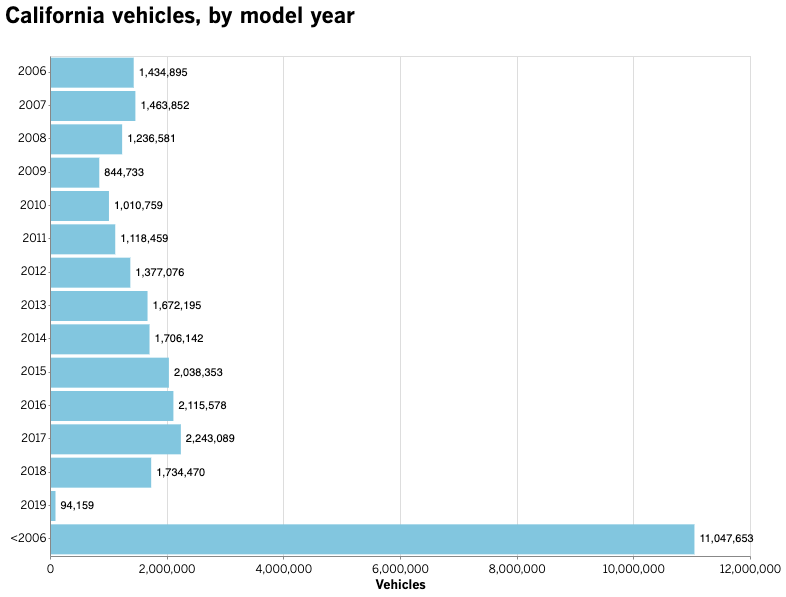

In [70]:
model_year_chart = alt.Chart(model_year).mark_bar().encode(
).mark_bar().encode(
    y=alt.Y('model_year:N', title=" ", axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("vehicles:Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

model_year_chart_text = model_year_chart.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(text=alt.Text('vehicles:Q', format=',')
)

(model_year_chart + model_year_chart_text).properties(height=500, width=700, title='California vehicles, by model year')

### Which types of alternative fuel models are most common?

In [71]:
fuel = vehicles.groupby(['fuel']).agg('sum').reset_index()

In [72]:
fuel.fuel.tolist()

['Battery Electric',
 'Diesel and Diesel Hybrid',
 'Flex-Fuel',
 'Gasoline',
 'Hybrid Gasoline',
 'Hydrogen Fuel Cell',
 'Natural Gas',
 'Other',
 'Plug-in Hybrid']

In [73]:
# Diesel and Diesel Hybrid + Flex-Fuel + Gasoline + Hybrid Gasoline
(fuel.iloc[1,1] + fuel.iloc[2,1] + fuel.iloc[3,1] + fuel.iloc[4,1])

30659434

# Chart the fuel type counts

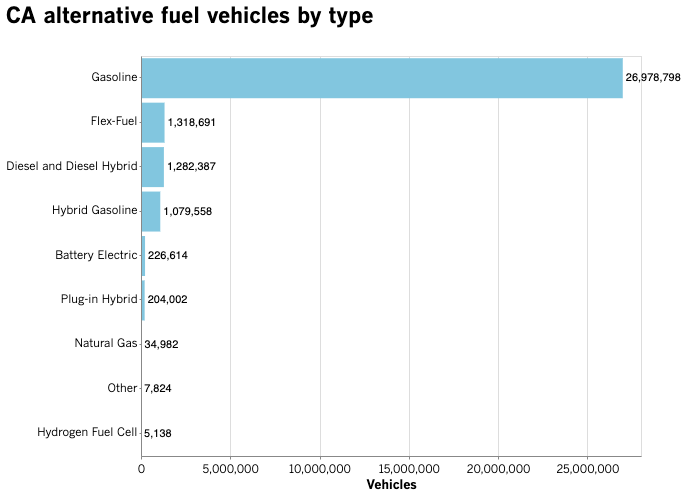

In [74]:
chart_fuels = alt.Chart(fuel).mark_bar().encode(
    y=alt.Y('fuel:N', title=' ',
        sort=alt.EncodingSortField(
            field="vehicles",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(vehicles):Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

chart_fuels_text = chart_fuels.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(text=alt.Text('sum(vehicles)', format=',')
)


(chart_fuels + chart_fuels_text)\
.properties(height=400, width=500, title='CA alternative fuel vehicles by type')

--- 

## Where are these vehicles?

In [75]:
zip_code = vehicles.groupby(['zip']).agg('sum').reset_index()

In [76]:
zip_code_nongas = nongas.groupby(['zip']).agg('sum').reset_index()

### Which ZIP codes have the most alternative fuel vehicles? (Airport areas, it seems)

In [77]:
zip_code_nongas.sort_values(by='vehicles',\
    ascending=False).head(10)

,zip,vehicles
2856,OOS,152537
45,90045,18587
12,90012,14204
1516,94080,12017
929,92626,11550
775,92335,11289
1206,93308,11286
426,91710,10929
1050,92868,10614
655,92154,10415


### Pivot on ZIP code and widen out the dataframe to count vehicle types across them

In [78]:
sum_by_zip = pd.pivot_table(vehicles, values='vehicles', \
                            index=['zip'], columns=['fuel'], aggfunc=np.sum, fill_value=0).reset_index()

sum_by_zip.columns = sum_by_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Which type is most common in each ZIP code? 

In [79]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [80]:
sum_by_zip.sort_values(by='total', ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total
2915,OOS,2952,51588,76741,536546,17872,37,1433,240,1674,689083
45,90045,433,826,12184,118089,4578,19,159,3,385,136676
1528,94080,309,2088,4307,116323,4987,9,60,17,240,128340
661,92154,121,5747,3045,67610,1330,0,23,8,141,78025
192,90650,136,1817,2779,69920,1542,5,94,15,252,76560


### Group the lesser-used fuel types into an 'other' category

In [81]:
sum_by_zip['other'] = sum_by_zip.apply\
    (lambda x: x['hydrogen_fuel_cell'] + x['natural_gas'] + x['other'], axis=1)
sum_by_zip.drop(['hydrogen_fuel_cell', 'natural_gas'], axis=1, inplace=True)
sum_by_zip.drop([0], inplace=True)

### Which non-gas vehicle is most popular — the 'winner' — in each zip?

In [82]:
sum_by_zip['winner'] = \
sum_by_zip[['hybrid_gasoline','battery_electric','diesel_and_diesel_hybrid',\
                   'flex_fuel','plug_in_hybrid', 'other']].idxmax(axis=1)

In [83]:
sum_by_zip.sort_values(by='total', ascending=False).head(10)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
2915,OOS,2952,51588,76741,536546,17872,1710,1674,689083,flex_fuel
45,90045,433,826,12184,118089,4578,181,385,136676,flex_fuel
1528,94080,309,2088,4307,116323,4987,86,240,128340,hybrid_gasoline
661,92154,121,5747,3045,67610,1330,31,141,78025,diesel_and_diesel_hybrid
192,90650,136,1817,2779,69920,1542,114,252,76560,flex_fuel
782,92335,51,6640,3267,65154,773,461,97,76443,diesel_and_diesel_hybrid
335,91331,54,1809,2814,69639,1316,47,175,75854,flex_fuel
783,92336,185,2335,3083,67615,1810,55,443,75526,flex_fuel
342,91342,162,2926,2924,66392,1972,44,312,74732,diesel_and_diesel_hybrid
1667,94565,144,1811,3045,66285,2001,52,268,73606,flex_fuel


### De-slugify the 'winner' category

In [84]:
sum_by_zip['winner'] = sum_by_zip['winner'].str.replace('_', ' ', regex=False).str.capitalize()

In [85]:
sum_by_zip['altshare'] = (((sum_by_zip['total']-sum_by_zip['gasoline'])/sum_by_zip['total'])*100).round()

In [86]:
sum_by_zip.sort_values(by='total', ascending=False).head(10)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner,altshare
2915,OOS,2952,51588,76741,536546,17872,1710,1674,689083,Flex fuel,22.00
45,90045,433,826,12184,118089,4578,181,385,136676,Flex fuel,14.00
1528,94080,309,2088,4307,116323,4987,86,240,128340,Hybrid gasoline,9.00
661,92154,121,5747,3045,67610,1330,31,141,78025,Diesel and diesel hybrid,13.00
192,90650,136,1817,2779,69920,1542,114,252,76560,Flex fuel,9.00
782,92335,51,6640,3267,65154,773,461,97,76443,Diesel and diesel hybrid,15.00
335,91331,54,1809,2814,69639,1316,47,175,75854,Flex fuel,8.00
783,92336,185,2335,3083,67615,1810,55,443,75526,Flex fuel,10.00
342,91342,162,2926,2924,66392,1972,44,312,74732,Diesel and diesel hybrid,11.00
1667,94565,144,1811,3045,66285,2001,52,268,73606,Flex fuel,10.00


### Use the "jenks" method to set fair breaks for total field

In [87]:
breaks \
= jenkspy.jenks_breaks(sum_by_zip.total, nb_class=7)

In [88]:
breaks

[11.0, 7324.0, 20016.0, 33181.0, 49901.0, 78025.0, 136676.0, 689083.0]

---

### Export merged polygon geodataframe as GeoJSON

In [89]:
zips_poly.to_file('/Users/mhustiles/data/data/GIS/zips_poly.geojson', driver='GeoJSON')

In [90]:
zips_poly_merged = zips_poly.merge(sum_by_zip, on='zip')

In [91]:
zips_poly_merged.columns

Index(['objectid', 'zip', 'po_name', 'pop2012', 'white', 'black', 'ameri_es',
       'asian', 'hawn_pi', 'hispanic', 'other_x', 'mult_race', 'med_age',
       'ave_hh_sz', 'marhh_chd', 'families', 'ave_fam_sz', 'hse_units', 'sqmi',
       'geometry', 'battery_electric', 'diesel_and_diesel_hybrid', 'flex_fuel',
       'gasoline', 'hybrid_gasoline', 'other_y', 'plug_in_hybrid', 'total',
       'winner', 'altshare'],
      dtype='object')

In [92]:
# zips_poly_merged_drop = ['objectid', 'zip', 'po_name', 'sqmi', 
#                         'battery_electric', 'diesel_and_diesel_hybrid', 'flex_fuel',
#                          'gasoline', 'hybrid_gasoline', 'other_y', 'plug_in_hybrid', 'total',
#                          'winner', 'altshare']
# zips_poly_merged.drop(zips_poly_merged_drop, inplace=True, axis=1)

In [93]:
zips_poly_merged.to_file('/Users/mhustiles/data/data/GIS/zips_poly_merged.geojson', driver='GeoJSON')

### Export with Tesla totals

In [94]:
tesla_zips_poly_merged = zips_poly.merge(tesla_zips_slim, on='zip')

In [95]:
tesla_zips_poly_merged.to_file('/Users/mhustiles/data/github/notebooks/\
california-fuel-vehicles/output/tesla_zips.geojson', driver='GeoJSON')

In [96]:
tesla_zips_poly_merged.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry,teslas,tesla_rate
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.00,2.42,2925,7671,2.98,12304,5.90,"POLYGON ((-122.277034540571 37.5343582023783, ...",305,13.25
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.60,2.43,4798,12179,3.06,20020,13.00,"POLYGON ((-122.377279066574 37.6056199838047, ...",797,17.53
2,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.00,3.10,4637,13991,3.54,20103,5.70,"POLYGON ((-122.502826389233 37.7081318430574, ...",79,1.75
3,4803,94019,Half Moon Bay,18476,14195,137,128,718,20,5533,2646,693,42.30,2.75,1729,4653,3.23,7132,73.10,"(POLYGON ((-122.428748182297 37.6041545461498,...",86,5.80
4,4902,93446,Paso Robles,44990,35268,719,465,721,68,12245,4582,1602,38.60,2.67,3930,11561,3.10,18303,344.40,"POLYGON ((-121.060394531453 35.7388181902079, ...",21,0.50


### Merge ZIP points with Tesla totals

In [97]:
teslas_poimt_merged = ca_zips_point.merge(tesla_zips_slim, on='zip')

In [98]:
teslas_poimt_merged.head()

,zip,city,state,geometry,teslas,tesla_rate
0,90004,Los Angeles,CA,POINT (-118.31 34.07),97,2.84
1,90005,Los Angeles,CA,POINT (-118.31 34.05),16,0.90
2,90008,Los Angeles,CA,POINT (-118.34 34),30,1.51
3,90012,Los Angeles,CA,POINT (-118.24 34.06),57,1.58
4,90014,Los Angeles,CA,POINT (-118.25 34.04),12,3.43


In [99]:
teslas_poimt_merged.to_file('output/teslas_point_merged.geojson', driver='GeoJSON')

### Merge ZIP points with all vehicle totals

In [100]:
ca_zips_point_merged = ca_zips_point.merge(sum_by_zip, on='zip')

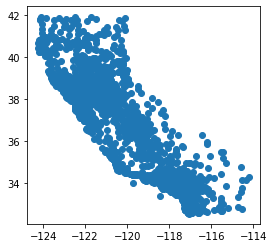

In [101]:
ca_zips_point_merged.plot()

### Export merged points geodataframe as GeoJSON

In [102]:
ca_zips_point_merged.head(1)

,zip,city,state,geometry,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner,altshare
0,90001,Los Angeles,CA,POINT (-118.24 33.97),10,865,1276,32023,466,23,46,34709,Flex fuel,8.00


In [103]:
ca_zips_point_merged.to_file('/Users/mhustiles/data/data/fuel/ca_zips_point_merged.geojson', driver='GeoJSON')

### Convert polygons to mbtiles for Mapbox. Export.

In [104]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson

For layer 0, using name "ca_zips_poly_merged"
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson: No such file or directory
0 features, 10 bytes of geometry, 16 bytes of separate metadata, 0 bytes of string pool
Did not read any valid geometries


### Convert points to mbtiles for Mapbox. Export.

In [105]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.geojson

For layer 0, using name "ca_zips_point_merged"
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.geojson: No such file or directory
0 features, 10 bytes of geometry, 16 bytes of separate metadata, 0 bytes of string pool
Did not read any valid geometries


### Convert Tesla polygons to mbtiles for Mapbox. Export.

In [106]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/teslas_poly_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/teslas_poly_merged.geojson

For layer 0, using name "teslas_poly_merged"
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/teslas_poly_merged.geojson: No such file or directory
0 features, 10 bytes of geometry, 16 bytes of separate metadata, 0 bytes of string pool
Did not read any valid geometries


---

See related [Twitter thread](https://twitter.com/stiles/status/1193416749116358656)